# Module 8 -- KNN and SVM
### Group Members: Gege Li, Zhihong Zhang, Zhijing Zhang

## Introduction

In this module, we are going to dig further from the last module and work on the same Federal Reserve Bank data set. In this assignment, construct and compare a series of K-Nearest Neighbor and Support Vector Machine models that predict whether or not a given mortgage application is likely to be denied. 


## Exploratory Data Analysis

In [ ]:
#deal with imbalanced data
!pip install imbalanced-learn

In [ ]:
#prepared library 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import library for dealing with imbalance data
import imblearn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# check and read the dataset from github
 
df = pd.read_csv('https://raw.githubusercontent.com/steinszzh/DAV6150/master/m7hw/M7_Data.csv')
df.head()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


In [ ]:
#replace the name
df.rename(columns={'Unnamed: 0':'Unique ID'}, inplace=True)
#check
df.head()

,Unique ID,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


Now we have changed the column names.

Before we start data analysis, summaries, and explanations of these attributes were given.
The whole dataset contains 2381 rows and 13 attributes except the unique ID . The attributes are showed as follows:

- dir:
debt payments to total income ratio

- hir:
housing expenses to income ratio

- lvr：
ratio of size of loan to assessed value of property

- ccs：
consumer credit score from 1 to 6 (a low value being a good score)

- mcs：
mortgage credit score from 1 to 4 (a low value being a good score)

- pbcr：
public bad credit record ?

- dmi：
denied mortgage insurance ?

- self：
self employed ?

- single：
is the applicant single ?

- uria：
1989 Massachusetts unemployment rate in the applicant's industry

- condominium：
is unit a condominium ? (was called comdominiom in version 0.2-9 and earlier versions of the package)

- black：
is the applicant black ?

- deny：
mortgage application denied ?

In [ ]:
df.dtypes

Unique ID        int64
dir            float64
hir            float64
lvr            float64
ccs            float64
mcs            float64
pbcr            object
dmi             object
self            object
single          object
uria           float64
comdominiom      int64
black           object
deny            object
dtype: object

From these  explanations of attributes and the data type showed, we know that:
-  __'dir', 'hir', 'lvr', 'uria'__ are continous data.
- __'ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single', 'comdominiom' and 'black'__  are catrgerical data.
-  Specifically, 'pbcr', 'dmi', 'self', 'single', 'condominium' and 'black' are binomial.

So we can change the data tpye.

In [ ]:
# using dictionary to convert specific columns 
convert_dict = {'ccs': object, 
                'mcs': object,
                'comdominiom': object
               } 
  
df = df.astype(convert_dict) 
df.dtypes

Unique ID        int64
dir            float64
hir            float64
lvr            float64
ccs             object
mcs             object
pbcr            object
dmi             object
self            object
single          object
uria           float64
comdominiom     object
black           object
deny            object
dtype: object

Then we check whether there is null value or not.

In [ ]:
#check the null value
df.isnull().sum()

Unique ID      0
dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           1
dmi            0
self           1
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

There are two missing values across the whole data set. Although it can be due to nature of lacking of data, we choose to take these two row away because it is less than 0.1% of whole dataset. Taking out two rows will not shift a lot on PDF.

In [ ]:
df_num = df.copy()

In [ ]:
#Removing all null values row
df_num = df_num.dropna(subset=['pbcr','self'])
df_num.isnull().sum()

Unique ID      0
dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           0
dmi            0
self           0
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

In [ ]:
#describe the dataset
df_num.describe().T 

,count,mean,std,min,25%,50%,75%,max
Unique ID,2380.0,1190.500000,687.191143,1.00,595.750000,1190.500000,1785.250000,2380.00
dir,2380.0,0.330814,0.107257,0.00,0.280000,0.330000,0.370000,3.00
hir,2380.0,0.255346,0.096656,0.00,0.214000,0.260000,0.298825,3.00
lvr,2380.0,0.737776,0.178751,0.02,0.652681,0.779536,0.868459,1.95
uria,2380.0,3.774496,2.027062,1.80,3.100000,3.200000,3.900000,10.60


Based on checking of these attributes, now we can draw some plots to see the insight of the data.

First of all, we will see the response variable-- __deny__:

Text(0.5, 1.0, 'mortgage application denied or not')

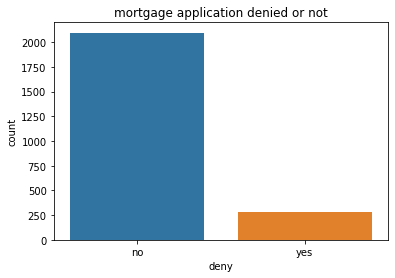

In [ ]:
# plots distribution of whether deny or not
sns.countplot(x='deny',data=df_num); 

# give the plot a title
plt.title('mortgage application denied or not')

In [ ]:
# calculate percentage of null error rate
df_num['deny'].value_counts()

no     2095
yes     285
Name: deny, dtype: int64

Based on our response variable-deny, it is clear to see that nearly __88.025%__ of people are not denied(2095/(2095+285)). It is clearly an imbalanced response variable. It will create some troubles in building up the models. Later we will use Synthetic Minority Oversampling Technique (SMOTE) technique to clear up the data for modeling. SMOTE will make the data set be a balanced data set and fix the null error rate to __50%__ (0.5).

Then we check other attributes and check with the condition that the application is denied or not.

Firstly we will compare these eight categorical attributes and then we compare them with numerical attributes. 


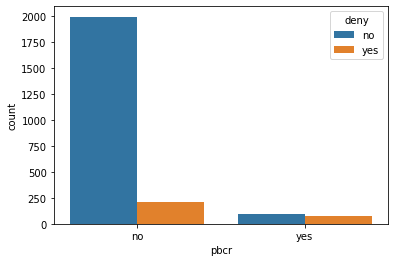

In [ ]:
# compare to the response features ---pbcr
sns.countplot(x='pbcr',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of pbcr vs deny')

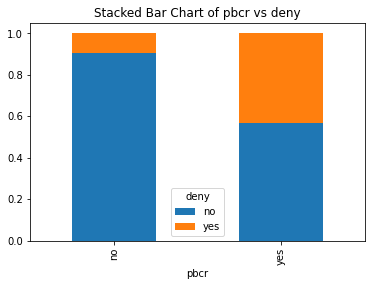

In [ ]:
# pbcr
table=pd.crosstab(df_num.pbcr,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of pbcr vs deny')

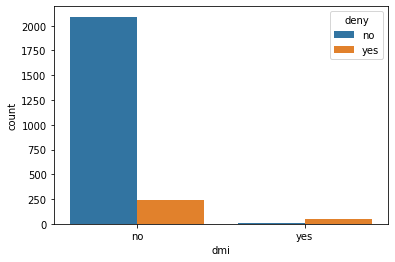

In [ ]:
# compare to the response features ---dmi
sns.countplot(x='dmi',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of dmi vs deny')

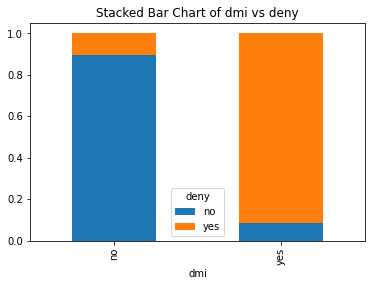

In [ ]:
# dmi
table=pd.crosstab(df_num.dmi,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of dmi vs deny')

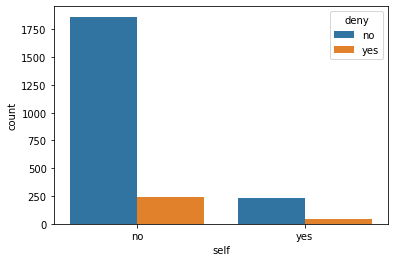

In [ ]:
# compare to the response features ---self
sns.countplot(x='self',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of self vs deny')

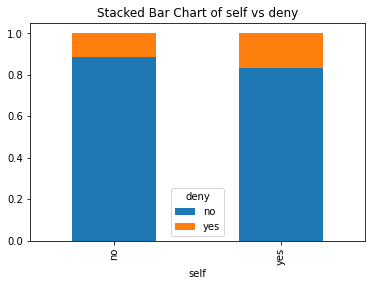

In [ ]:
# self
table=pd.crosstab(df_num.self,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of self vs deny')

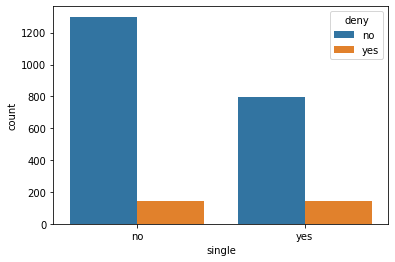

In [ ]:
# compare to the response features ---single
sns.countplot(x='single',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of single vs deny')

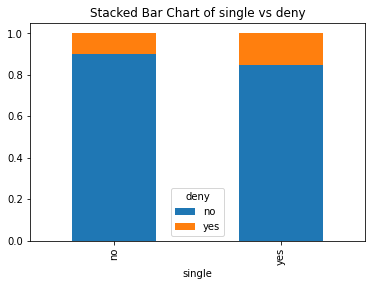

In [ ]:
# single
table=pd.crosstab(df_num.single,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of single vs deny')

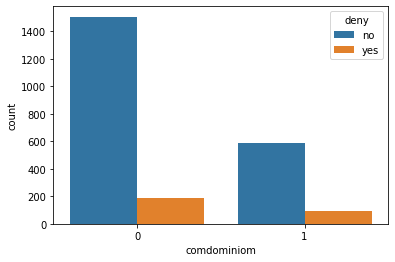

In [ ]:
# compare to the response features ---comdominiom
sns.countplot(x='comdominiom',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of comdominiom vs deny')

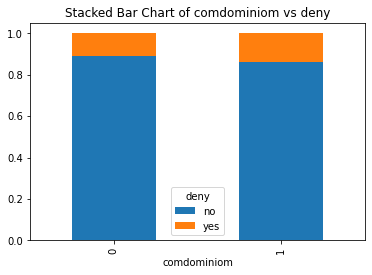

In [ ]:
# comdominiom
table=pd.crosstab(df_num.comdominiom,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of comdominiom vs deny')

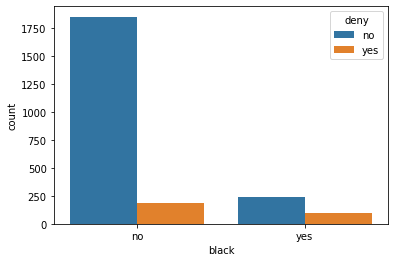

In [ ]:
# compare to the response features ---black
sns.countplot(x='black',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of black vs deny')

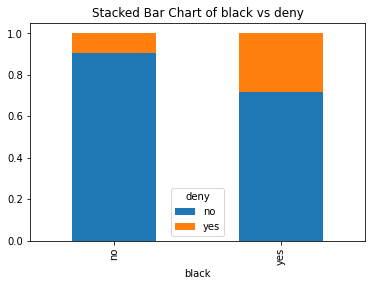

In [ ]:
# black
table=pd.crosstab(df_num.black,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of black vs deny')

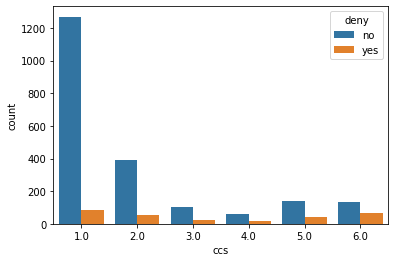

In [ ]:
# compare to the response features ---ccs
sns.countplot(x='ccs',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of ccs vs deny')

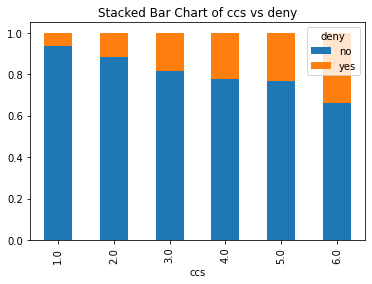

In [ ]:
# ccs
table=pd.crosstab(df_num.ccs,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of ccs vs deny')

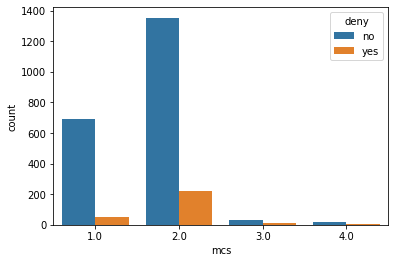

In [ ]:
# compare to the response features ---mcs
sns.countplot(x='mcs',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of mcs vs deny')

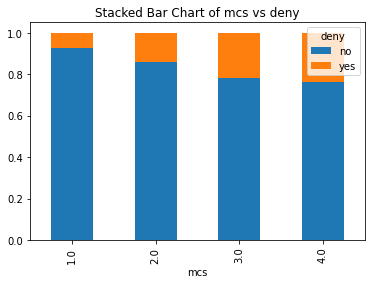

In [ ]:
# mcs
table=pd.crosstab(df_num.mcs,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of mcs vs deny')

From these eight categorical attributes, we have these insights and findings
- pbcr: it is a fine indicator, we can see that if pbcr is yes, deny ratio increase a lot. 
- dmi: it is a very nice indicator, if dmi is yes, it is more likely to be denied. 
- self:It is not a bad indicator. It is about the same ratio between deny or not across self. But deny ratio is higher when applicant is self-employed
- condominium : It is not a good indicator. It is obvious that deny rate is about the same across whether it is condominium or not.
- black: It is a good indicator. We can find that if applicant is black, deny rate is higher(yes/ not denied).
- single: It is a good indicator. We can tell that it is almost identical number of counts on denied rate over single or not. But there is more counts for not single. It means that it is more likely to be denied if applicant is single. 
- ccs: as the ccs value increase, the ratio of deny ratio, which can be identified as yes / no also increase. On the other hand, it means that when ccs is higher, it is more likely to be denied but majority is still accepted. 
- mcs：Overall it is not a good indicator, and the pattern is not clear enough.  We can find as mcs increase,  rate of deny(yes/no) is also increasing as well. It is not as obvious as ccs.

Based on these attributes, we choose these attributes as our choice because they are more clear to show the difference to deny: 
**pbcr, dmi, single,black, ccs**

Then we can do some EDA on the continuous features.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


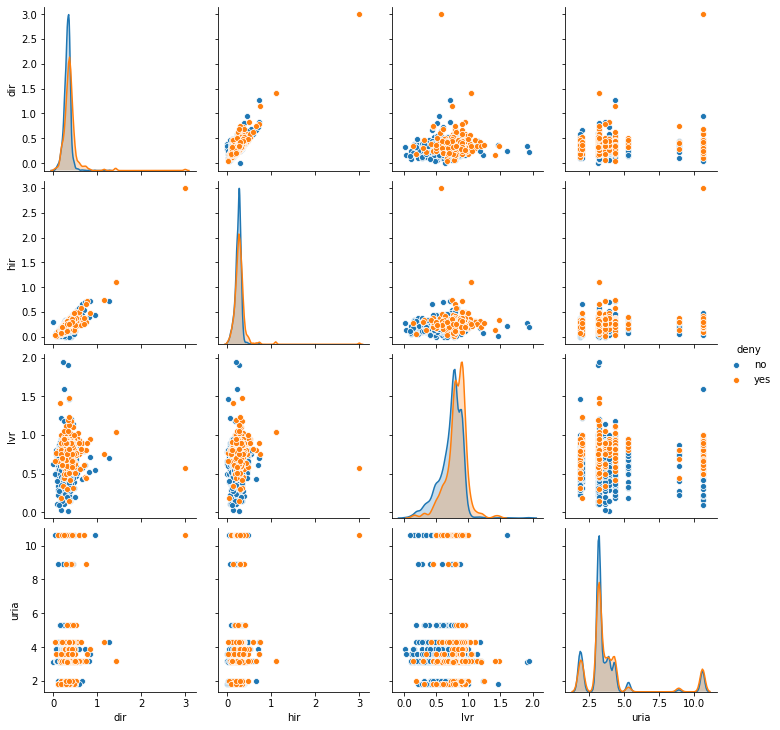

In [ ]:
# compare to the response features--- pari plot
df_sub = df_num[['dir','hir','lvr','uria','deny']]
sns.pairplot(df_sub, hue='deny', size=2.5)

Based on this pair plots:
- We can check whether attributes are correlated or not. 
- We find that 'dir' and 'hir' has some coorelation and they have some collinear relationship.  Dir vs hir plot(1,2) and hir vs dir plot(2,1) among these 16 plots showed this positive coorelation. 
- lvr and uria does not show some coorelations among these attributes.


From this plot we find that the 'uria' is different from other continuous features. We think that this is also a categorical data. Let's check.

In [ ]:
# 'uria'
df_num['uria'].value_counts()

3.2     877
3.1     275
3.9     229
4.3     220
1.8     217
3.6     174
10.6    159
2.0     148
5.3      65
8.9      16
Name: uria, dtype: int64

Now we can find that 'uria' only have 11 values. So in EDA part we will show this feature as categorical and re-run the EDA.

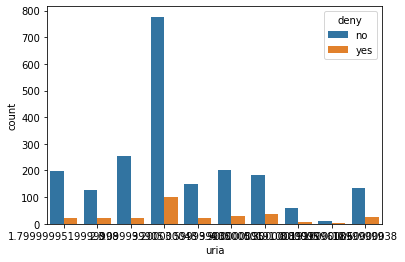

In [ ]:
# compare to the response features ---uria
sns.countplot(x='uria',hue='deny', data=df_num)

Text(0.5, 1.0, 'Stacked Bar Chart of uria vs deny')

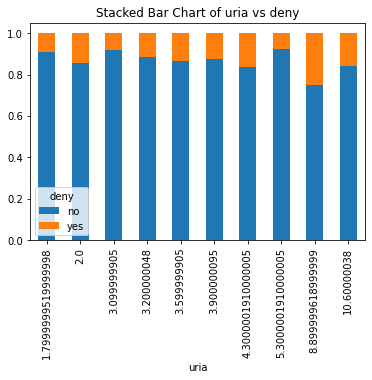

In [ ]:
# uria
table=pd.crosstab(df_num.uria,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of uria vs deny')

Then delete 'uria' and re-run the pair plot.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


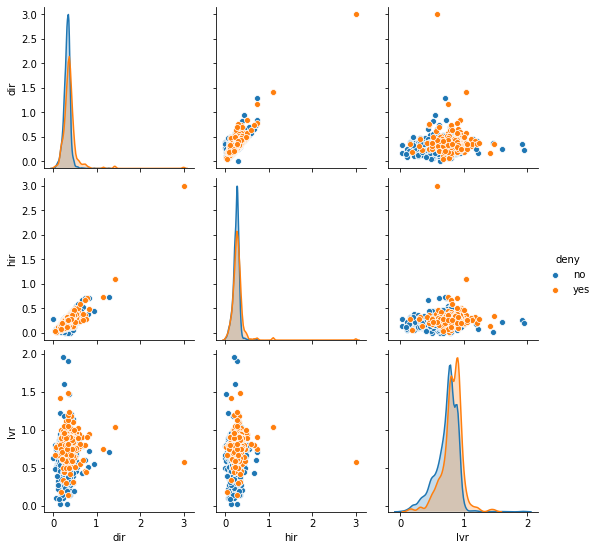

In [ ]:
# plot
df_sub = df_num[['dir','hir','lvr','deny']]
sns.pairplot(df_sub, hue='deny', size=2.5)

We can find that 'dir' and 'hir' has some correlation. So in later regression modeling we will only choose one as our feature.

## Data Preparation & Prepped Data Review 

**Firstly, we need to convert the categorical features into binary.**

In [ ]:
# replace value to 0 and 1 for categorical variable. 
# replace pbcr	dmi	self	single black and deny in order

df_num['pbcr'].replace({'no': 0, 'yes': 1}, inplace=True)

df_num['dmi'].replace({'no': 0, 'yes': 1}, inplace=True)

df_num['self'].replace({'no': 0, 'yes': 1}, inplace=True)

df_num['single'].replace({'no': 0, 'yes': 1}, inplace=True)

df_num['black'].replace({'no': 0, 'yes': 1}, inplace=True)

df_num['deny'].replace({'no': 0, 'yes': 1}, inplace=True)

Now we have converted the binary features into 0 and 1. Re-run the EDA part shown as follow:

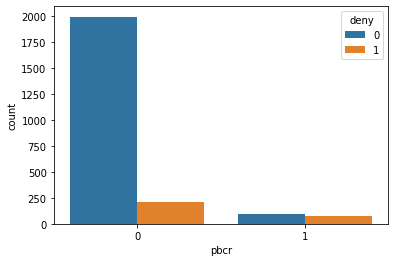

In [ ]:
# compare to the response features ---(six binomial feature + ccs,mcs)

sns.countplot(x='pbcr',hue='deny', data=df_num)
#sns.countplot(x='dmi',hue='deny', data=df_num)
#sns.countplot(x='self',hue='deny', data=df_num)
#sns.countplot(x='single',hue='deny', data=df_num)
#sns.countplot(x='black',hue='deny', data=df_num)
#sns.countplot(x='mcs',hue='deny', data=df_num)
#sns.countplot(x='ccs',hue='deny', data=df_num)

__Then we need to check the outliers and deal with it.__

Since we already now that there are only three continuous data, so we wil focus on 'dir', 'hir' and 'lvr'.

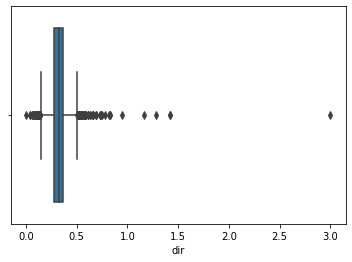

In [ ]:
# dir
sns.boxplot(x=df_num["dir"],data=df_num) 

We find there are some obvious outliers located around 3. Before we decided to remove these data points around 3 for its distance to our mean( it is more than 3 standard deviation away from our mean) . According to our knowledge, higher debt payments to total income ratio may indicate that the credibility of the applicants is lower and this series of data may explain some of the denied data. Based on this belief, we firstly test with building new categorical value based on this numerical value. This selected range of values are based on the common belief of debt-to-income ratio. Based on our reference, in pure risk perspective, 0.4 or lower is considered better ratio, and 0.6 is alreay a risky debt ratio. In order to  fits this three equal range interval, We define 0 to 0.5 is low debt, 0.5 to 1 is medium and over it is a high debt ratio. This medium is a relative term in this scenario, although it is already a high risk in a more general sense. 

In [ ]:
#function for categorize numerical data
def level_rate(x):
    '''this function tries to categorize the numerical value for debt
     '''
    if x < .5:
        return 'low '
    elif .5 < x < 1:
        return 'medium '
    return 'high'
#apply equation for model
df_num['debt_level'] = df_num['dir'].apply(level_rate)
df_num.head()

,Unique ID,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny,debt_level
0,1,0.221,0.221,0.800000,5,2,0,0,0,0,3.9,0,0,0,low
1,2,0.265,0.265,0.921875,2,2,0,0,0,1,3.2,0,0,0,low
2,3,0.372,0.248,0.920398,1,2,0,0,0,0,3.2,0,0,0,low
3,4,0.320,0.250,0.860465,1,2,0,0,0,0,4.3,0,0,0,low
4,5,0.360,0.350,0.600000,1,1,0,0,0,0,3.2,0,0,0,low


Text(0.5, 1.0, 'Stacked Bar Chart of debt_level vs deny')

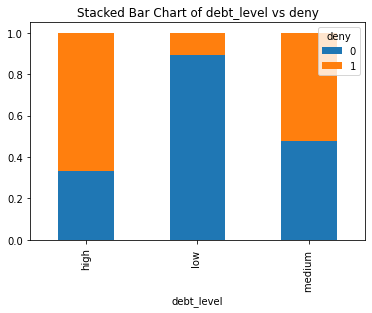

In [ ]:
# debt level 
table=pd.crosstab(df_num.debt_level,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of debt_level vs deny')

Now it is clear that, this new built categorical attributes is a good indicator for whether applicant will be denied or not. 

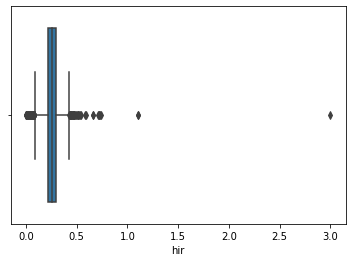

In [ ]:
# hir
sns.boxplot(x=df_num["hir"],data=df_num) 

As we stated before in our pairplot, hir is correlated with dir. Based on the general understanding of this attribute, when the housing expense to income ratio is lower, applicant's financial status is better. This plot also shows some similarities to dir( debt to income ratio). Due to the box plot have a similar distribution,  we also used the same formula for building house expense categorical attributes. We follow the same metrics since this will also provide same range from value distribution.

In [ ]:
#apply equation for model
def finance_logic(x):
    '''this function tries to categorize the numerical value for debt
     '''
    if x < .5:
        return 'low '
    elif .5 < x < 1:
        return 'medium '
    return 'high'



df_num['house_expense'] = df_num['hir'].apply(level_rate)
df_num.head()

,Unique ID,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny,debt_level,house_expense
0,1,0.221,0.221,0.800000,5,2,0,0,0,0,3.9,0,0,0,low,low
1,2,0.265,0.265,0.921875,2,2,0,0,0,1,3.2,0,0,0,low,low
2,3,0.372,0.248,0.920398,1,2,0,0,0,0,3.2,0,0,0,low,low
3,4,0.320,0.250,0.860465,1,2,0,0,0,0,4.3,0,0,0,low,low
4,5,0.360,0.350,0.600000,1,1,0,0,0,0,3.2,0,0,0,low,low


Text(0.5, 1.0, 'Stacked Bar Chart of house_expense vs deny')

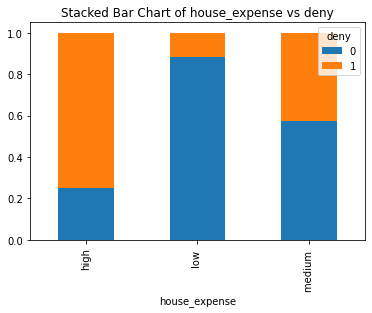

In [ ]:
# housing expense
table=pd.crosstab(df_num.house_expense,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of house_expense vs deny')

As we expected, house expense ratio also showed a similar pattern like debt to income ratio. For further modeling , we can use new built attributes for modeling. Since dir and hir are correlated, we can either use hir or dir but not using both attributes. 

In [ ]:
#build new binary attributes
#function for categorize numerical data
def binary_ratio(x):
    '''this function tries to make binary data
     '''
    if x < .5:
        return 1
    elif .5 < x < 1:
        return 1
    return 0
#apply equation for model
df_num['affordable_house'] = df_num['hir'].apply(binary_ratio)
df_num.head()

,Unique ID,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny,debt_level,house_expense,affordable_house
0,1,0.221,0.221,0.800000,5,2,0,0,0,0,3.9,0,0,0,low,low,1
1,2,0.265,0.265,0.921875,2,2,0,0,0,1,3.2,0,0,0,low,low,1
2,3,0.372,0.248,0.920398,1,2,0,0,0,0,3.2,0,0,0,low,low,1
3,4,0.320,0.250,0.860465,1,2,0,0,0,0,4.3,0,0,0,low,low,1
4,5,0.360,0.350,0.600000,1,1,0,0,0,0,3.2,0,0,0,low,low,1


In [ ]:
#apply equation for model
df_num['affordable_debt'] = df_num['dir'].apply(binary_ratio)

In [ ]:
#replace column values for affordable place
#df_num['affordable_house'].replace({'low': '1', 'medium': '1','high': '0' }, inplace=True)
#df_num.head()

In [ ]:
df_num.affordable_house

0       1
1       1
2       1
3       1
4       1
       ..
2375    1
2376    1
2377    1
2378    1
2379    1
Name: affordable_house, Length: 2380, dtype: int64

In [ ]:
df_num.head()

,Unique ID,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny,debt_level,house_expense,affordable_house,affordable_debt
0,1,0.221,0.221,0.800000,5,2,0,0,0,0,3.9,0,0,0,low,low,1,1
1,2,0.265,0.265,0.921875,2,2,0,0,0,1,3.2,0,0,0,low,low,1,1
2,3,0.372,0.248,0.920398,1,2,0,0,0,0,3.2,0,0,0,low,low,1,1
3,4,0.320,0.250,0.860465,1,2,0,0,0,0,4.3,0,0,0,low,low,1,1
4,5,0.360,0.350,0.600000,1,1,0,0,0,0,3.2,0,0,0,low,low,1,1


As we showed, we created ,affordable housing, a new binary classifier based on house expense to income ratio. 1 means it is affordable, 0 means unaffordable.

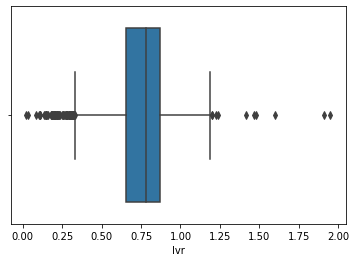

In [ ]:
# lvr
sns.boxplot(x=df_num["lvr"],data=df_num) 

lvr, ratio of size of loan to assessed value of property, similar to the previous two continuous attributes, also means that the higher, the worse financial status applicant has. We did not find a good reference on explaining these attributes but we had the sense that ratio above one is not a favorable status. Then we launched a similar method to build a categorical variable based on these numerical values. 

In [ ]:
#build new binary attributes
#function for categorize numerical data
def binary_lvr(x):
    '''this function tries to make binary data
     '''
    if x < 1:
        return 1
    return 0
#apply equation for model
df_num['suitable_loan'] = df_num['lvr'].apply(binary_lvr)
df_num.head()

,Unique ID,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny,debt_level,house_expense,affordable_house,affordable_debt,suitable_loan
0,1,0.221,0.221,0.800000,5,2,0,0,0,0,3.9,0,0,0,low,low,1,1,1
1,2,0.265,0.265,0.921875,2,2,0,0,0,1,3.2,0,0,0,low,low,1,1,1
2,3,0.372,0.248,0.920398,1,2,0,0,0,0,3.2,0,0,0,low,low,1,1,1
3,4,0.320,0.250,0.860465,1,2,0,0,0,0,4.3,0,0,0,low,low,1,1,1
4,5,0.360,0.350,0.600000,1,1,0,0,0,0,3.2,0,0,0,low,low,1,1,1


Text(0.5, 1.0, 'Stacked Bar Chart of suitable_loan vs deny')

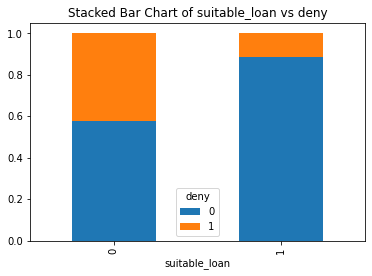

In [ ]:
# suitable_loan 
table=pd.crosstab(df_num.suitable_loan,df_num.deny)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of suitable_loan vs deny')

Although it is not as obvious as previous two attributes, this plot still fits our common sense of loan size.
It is more likely to be denied if applicant has a larger size of loan. 

This is a quick summary of what we did for this section of numerical attributes
- We figured these "outlier" may not be the problem. Instead, it can become a nice indicator when we used to build our binary classifiers
- We built three binary attributes based on some insights of these attributes. They all fit our prior knowledge of loan, debt and living expenses. 
- We believe that both binary attributes built upon dir and hir can be helpful for further modeling. Since these two attributes have collinearity, we can only choose one for modeling.

- Another uncorrelated attribute lvr can also be used to build model. We call this loan size to be one classifier.

In the next section, we will use five categorical attributes which we discovered from EDA along with three categorical attributes which were built from numerical attributes to create our four models. 

We will also apply smote in our modeldue to this imbalanced variable of deny. Since SMOTE will be applied, now it is a balanced data set and we can directly compare the output to null error rate 0.5 . 

## KNN + SVM Modeling & Select Models
In this session along with Select Modeling session, we basically merges these two section together. KNN and SVM Modeling mainly showed how we combine these attributes and check results with trainind data. Selcet Model section we will use whole data set to test model. 

### KNN model

Since KNN requires the selection of K, as we know, a small value of k means that noise will have a higher influence on the result and a large value make it computationally expensive.
We would choose one k=3 as common starter and choose another K value based on the square root of sample size n as our models. 

__model 1__

Based on our EDA part, in model one we will use 'pbcr', 'dmi', 'black', 'ccs' and 'single' these five features. In this model, we also run SMOTE to resample imbalanced samples.  We can find it will make a balanced data set of 3352 samples.

In [ ]:
#KNN -- model 1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#apply smote
from imblearn.over_sampling import SMOTE
predictors1 = ['pbcr', 'dmi', 'black', 'ccs','single']
X1 = df_num[predictors1]
y1 = df_num.deny

#Try to use SMOTE to resample 

X1, y1  = SMOTE().fit_resample(df_num[predictors1], df_num.deny)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.8, random_state=22)


#set k=3
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train1, y_train1)
prediction = knn.predict(X_test1)
score = knn.score(X_test1,y_test1)
print('before modeling',y_test1)
print("after modeling:",prediction)
print("score:",score)


from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test1,prediction))
print(classification_report(y_test1,prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


before modeling [0 1 1 ... 0 1 0]
after modeling: [0 0 1 ... 1 0 1]
score: 0.6596062052505967
[[1113  568]
 [ 573 1098]]
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1681
           1       0.66      0.66      0.66      1671

    accuracy                           0.66      3352
   macro avg       0.66      0.66      0.66      3352
weighted avg       0.66      0.66      0.66      3352



__Model 2__

For model two, we not only picked five features from the categorical data, we also introduced extra attributes based on the continuous variables. Since dir and hir has collinearity, we can choose either of them for modeling. We choose dir to make a new binary classifier( affordable_debt) for feature.

In [ ]:
#KNN -- model 2

predictors2 = ['pbcr', 'dmi', 'black', 'ccs','single','affordable_debt']
X2 = df_num[predictors2]
y2 = df_num.deny

#Try to use SMOTE to resample 

X2, y2  = SMOTE().fit_resample(df_num[predictors2], df_num.deny)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.8, random_state=22)

#set k=3
knn = KNeighborsClassifier(n_neighbors=3)


knn.fit(X_train2, y_train2)
prediction = knn.predict(X_test2)
score = knn.score(X_test2,y_test2)
print('before modeling',y_test2)
print("after modeling:",prediction)
print("score:",score)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test2,prediction))
print(classification_report(y_test2,prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


before modeling [0 1 1 ... 0 1 0]
after modeling: [1 1 0 ... 0 1 0]
score: 0.5238663484486874
[[ 729  952]
 [ 644 1027]]
              precision    recall  f1-score   support

           0       0.53      0.43      0.48      1681
           1       0.52      0.61      0.56      1671

    accuracy                           0.52      3352
   macro avg       0.52      0.52      0.52      3352
weighted avg       0.52      0.52      0.52      3352



__model 3__

Similar to Model two, we digger further from model 2 by adding one extra newly-built attribute -- suitable loan. 

In [ ]:
#KNN -- model 3

predictors3 = ['pbcr', 'dmi', 'black', 'ccs','single','affordable_debt', 'suitable_loan']
X3 = df_num[predictors3]
y3 = df_num.deny

#Try to use SMOTE to resample 

X3, y3  = SMOTE().fit_resample(df_num[predictors3], df_num.deny)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.8, random_state=22)


#set k=3
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train3, y_train3)
prediction = knn.predict(X_test3)
score = knn.score(X_test3,y_test3)
print('before modeling',y_test3)
print("after modeling:",prediction)
print("score:",score)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test3,prediction))
print(classification_report(y_test3,prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


before modeling [0 1 1 ... 0 1 0]
after modeling: [0 0 0 ... 0 1 0]
score: 0.7204653937947494
[[1263  418]
 [ 519 1152]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1681
           1       0.73      0.69      0.71      1671

    accuracy                           0.72      3352
   macro avg       0.72      0.72      0.72      3352
weighted avg       0.72      0.72      0.72      3352



In these three models, we mainly compared the situation when k= 3, and model 3 gives a better result on precision. Also, we want to compare the result with a larger k value.  Since there are 3352 samples, we use k=59 (the odd number which is close to the square root of the sample size). Therefore we modified a  bit on model 3 for this variation. 

In [ ]:
#KNN -- model 3 extension on larger k value

predictors3 = ['pbcr', 'dmi', 'black', 'ccs','single','affordable_debt', 'suitable_loan']
X3 = df_num[predictors3]
y3 = df_num.deny

#Try to use SMOTE to resample 

X3, y3  = SMOTE().fit_resample(df_num[predictors3], df_num.deny)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.8, random_state=22)


#set k=59
knn = KNeighborsClassifier(n_neighbors=59)

knn.fit(X_train3, y_train3)
prediction = knn.predict(X_test3)
score = knn.score(X_test3,y_test3)
print('before modeling',y_test3)
print("after modeling:",prediction)
print("score:",score)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test3,prediction))
print(classification_report(y_test3,prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


before modeling [0 1 1 ... 0 1 0]
after modeling: [0 0 0 ... 0 0 0]
score: 0.6960023866348448
[[1397  284]
 [ 735  936]]
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      1681
           1       0.77      0.56      0.65      1671

    accuracy                           0.70      3352
   macro avg       0.71      0.70      0.69      3352
weighted avg       0.71      0.70      0.69      3352



Now we can compare this extesnion form with original form. We can see when k=3, it gives the best result.  We can also expect in this specific dataset, large k will not help on getting better results. 

Then We start the SVM model. 

### SVM model 

- The linear kernel tricks is only suitable for linear data. 
- For non-linear data, other types of kernel tricks:
    - Radial Basis Function (RBF)
    - Gaussian (a special case of RBF)
    - Polynomial
    - sigmoid
    - other types

We assumpt that linear kernel may have the best perfermance. But at the same time we will also try polynomial, RBF and sigmoid kernel to compare. 

The same as KNN model, in SVM model 1 we will choose 'pbcr', 'dmi', 'black', 'ccs' and 'single'. In model 2 we will add 'affordable_debt'. In model 3 we will choose these features: 'pbcr', 'dmi', 'black', 'ccs','single','affordable_debt' and 'suitable_loan'.

Based on KNN, we noticed that model 3 provided the best performance. Therefore we will start with Model 3 in SVM and then model 2 and model 1.

__model 3__

In [ ]:
#model 3 
predictors3 = ['pbcr', 'dmi', 'black', 'ccs','single','affordable_debt', 'suitable_loan']

#Import svm model
from sklearn.svm import SVC
#Create a svm Classifier

#kernel='poly'
svclassifier = SVC(kernel='poly')
svclassifier.fit(X_train3, y_train3)
#Predict the response for test dataset
y_pred = svclassifier.predict(X_test3)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test3,y_pred))
print(classification_report(y_test3,y_pred))

[[1379  302]
 [ 677  994]]
              precision    recall  f1-score   support

           0       0.67      0.82      0.74      1681
           1       0.77      0.59      0.67      1671

    accuracy                           0.71      3352
   macro avg       0.72      0.71      0.70      3352
weighted avg       0.72      0.71      0.70      3352



In [ ]:
#kernel='rbf'
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train3, y_train3)

#Predict the response for test dataset
y_pred = svclassifier.predict(X_test3)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test3,y_pred))
print(classification_report(y_test3,y_pred))

[[1216  465]
 [ 522 1149]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1681
           1       0.71      0.69      0.70      1671

    accuracy                           0.71      3352
   macro avg       0.71      0.71      0.71      3352
weighted avg       0.71      0.71      0.71      3352



In [ ]:
#kernel='sigmoid'
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train3, y_train3)

#Predict the response for test dataset
y_pred = svclassifier.predict(X_test3)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test3,y_pred))
print(classification_report(y_test3,y_pred))

[[1155  526]
 [ 978  693]]
              precision    recall  f1-score   support

           0       0.54      0.69      0.61      1681
           1       0.57      0.41      0.48      1671

    accuracy                           0.55      3352
   macro avg       0.55      0.55      0.54      3352
weighted avg       0.55      0.55      0.54      3352



In [ ]:
#kernel='linear'
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train3, y_train3)
#Predict the response for test dataset
y_pred = svclassifier.predict(X_test3)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test3,y_pred))
print(classification_report(y_test3,y_pred))

[[1329  352]
 [ 592 1079]]
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      1681
           1       0.75      0.65      0.70      1671

    accuracy                           0.72      3352
   macro avg       0.72      0.72      0.72      3352
weighted avg       0.72      0.72      0.72      3352



Based on these four SVM models with different kernels, we already get a result better than KNN. 

Currently SVM model has better performance. We assumed that this result can be contributed to relatively small sample size. If there is a larger sample size, KNN may outperform the SVM models. 

Compare with these four SVM models:
- SVM with linear kernel performs best among these four. 
- Except for linear kernel, sigmoid is the best among the rest of the three.
- After we search a lot we know that sigmoid is better for solving classification problems. Gaussian and Polynomial have similar performance but Gaussian is a little bit better.

Therefore, we will only use linear kernel to construct the other two models and compare.

__model 2__

In [ ]:
#model 2 
predictors2 = ['pbcr', 'dmi', 'black', 'ccs','single','affordable_debt']

#kernel='linear'
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train2, y_train2)
#Predict the response for test dataset
y_pred = svclassifier.predict(X_test2)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test2,y_pred))
print(classification_report(y_test2,y_pred))

[[1343  338]
 [ 632 1039]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      1681
           1       0.75      0.62      0.68      1671

    accuracy                           0.71      3352
   macro avg       0.72      0.71      0.71      3352
weighted avg       0.72      0.71      0.71      3352



__model 1__

In [ ]:
#model 1 
predictors1 = ['pbcr', 'dmi', 'black', 'ccs','single']

#kernel='linear'
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train1, y_train1)
#Predict the response for test dataset
y_pred = svclassifier.predict(X_test1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test1,y_pred))
print(classification_report(y_test1,y_pred))

[[1346  335]
 [ 628 1043]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.74      1681
           1       0.76      0.62      0.68      1671

    accuracy                           0.71      3352
   macro avg       0.72      0.71      0.71      3352
weighted avg       0.72      0.71      0.71      3352



Now we have three SVM models with linear kernel. We can compare them and find that although the results are close in these linear kernels, model 3 performs slightly better due to a higher f1 score.

### Select Models 
From all these analyses and comparisons above, basically all the models can beat the null error rate of 0.5. Since the last module, we did not get a result for a balanced dataset. And the final result only showed that we beat a bit on the null error rate. In this module, all results are in balanced samples and we are safe to say most of the models can beat the logistic model for around 0.68 precision values. 

Overall Model 3 performs best in both KNN and SVM. When we compared our outcomes, SVM performs a bit better than KNN. Since their results are very close, and SVM only outperformed a little bit. We believe SVM with linear kernel wins in this dataset because the data set is relatively small. We may get a better result for KNN model if we would have much larger data sets. 

## Conclusions

After all the above, we can find that our best model is model 3 with SVM (linear kernel).

For predicting the denied candidates, it gave a precision of 0.75 and recall of 0.65. It beats the null-error rate (0.5) of the data set. In addition, this performance is better than module 7 of logistical regression since in last module the result is only a bit higher than the null error rate. 

## References：

1. https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
2. https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d
3.https://towardsdatascience.com/understanding-support-vector-machine-part-1-lagrange-multipliers-5c24a52ffc5e
4. debt ratio https://www.investopedia.com/ask/answers/021215/what-good-debt-ratio-and-what-bad-debt-ratio.asp